In [34]:
import os
import glob
import itertools
from random import randint
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path
import time

import matplotlib.cm as cm
from IPython.display import Image
import git

from rmgpy.molecule import Molecule
from rmgpy.data.base import Database

In [35]:
#Input file
rmg_model_path = '../ammonia/'
analysis_path = '../ammonia_analysis/results/O2_results'

In [36]:
#Git-python: checkout master branch
import git
repo = git.Repo(rmg_model_path)
date = time.localtime(repo.head.commit.committed_date)
git_date = f"{date[0]}_{date[1]}_{date[2]}_{date[3]}{date[4]}"
git_sha = str(repo.head.commit)[0:6]
git_msg = str(repo.head.commit.message)[0:50].replace(" ", "_").replace("'", "_").replace("\n", "")

current_commit = f"{git_date}_{git_sha}_{git_msg}"

current_commit

'2021_6_15_2228_a95fb7_training_500_673K_O88N066_no_gas_families_with_NOx'

In [37]:
# #checkout 1 commit back
# repo.git.checkout('HEAD^1')
# sha = str(repo.head.commit)
# msg = str(repo.head.commit.message)
# print(sha,': ', msg)

# #checkout 2 commit back
# repo = git.Repo('/work/westgroup/lee.ting/cantera/ammonia/')
# repo.git.checkout('HEAD^1')
# sha = repo.head.commit
# msg = repo.head.commit.message
# print(sha,': ', msg)

In [38]:
commit_list = []

# read in each filename into dictionary. get a list of the commit folders in this repo
for path in Path(analysis_path).rglob('*.csv'):
    path_str = str(path)
    start_index = path_str.find(analysis_path)
    
    if start_index != -1:
        commit = path_str[(start_index+len(analysis_path)):]
        print(commit)
        if "\n" in commit:
            end_char = commit.index("\n")
        else: 
            end_char = commit.index("/")
        
        commit = commit[:end_char]
        if commit not in commit_list:
            commit_list.append(commit)
        
print(commit_list)   

/2021_6_15_2228_a95fb7_training_500_673K_O88N066_no_gas_families_with_NOx/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_3.88e-05_energy_off_temp_598_O2_0_12689655172413794_NH3_0.csv
/2021_6_15_2228_a95fb7_training_500_673K_O88N066_no_gas_families_with_NOx/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_3.88e-05_energy_off_temp_598_O2_0_15379310344827588_NH3_0.csv
/2021_6_15_2228_a95fb7_training_500_673K_O88N066_no_gas_families_with_NOx/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_3.88e-05_energy_off_temp_598_O2_0_1806896551724138_NH3_0.csv
/2021_6_15_2228_a95fb7_training_500_673K_O88N066_no_gas_families_with_NOx/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_3.88e-05_energy_off_temp_598_O2_0_20758620689655172_NH3_0.csv
/2021_6_15_2228_a95fb7_training_500_673K_O88N066_no_gas_families_with_NOx/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_3.88e-05_ener

In [39]:
data_dict = {}

# Read last line from each CSV file to get the outlet concentrations from the PFR
# if "one_commit" is true, only run the master commit 
one_commit = False
if one_commit == True:
    commit_list = [current_commit]
    
for commit in commit_list:
    first_file = True
    for path in Path(f"/work/westgroup/lee.ting/cantera/ammonia_analysis/results/O2_results/{current_commit}").rglob('*.csv'):
        path_str = str(path)
        if os.stat(path_str).st_size >= 3e6:
            if first_file == True: 
                data = pd.read_csv(path_str)
                aggdata = data.tail(1)
                first_file = False
            else: 
                data = pd.read_csv(path_str)
                aggdata = aggdata.append(data.tail(1))
            data_dict.update({commit:aggdata})
        else:
            print(path_str)

## Reproduce plots from Rebrov

Rebrov, E. V., De Croon, M. H. J. M., & Schouten, J. C. (2002). Development of the kinetic model of platinum catalyzed ammonia oxidation in a microreactor. Chemical Engineering Journal, 90(1–2), 61–76. https://doi.org/10.1016/S1385-8947(02)00068-2


for reference: 

### $conversion(\%) = \frac{moles\_fed - moles\_out}{moles\_fed} $

### $selectivity(\%, N_2) = \frac{(2*r_{L6}+r_{L13})100}{r_{L5}} $

### $selectivity(\%, N_{2}O) = \frac{(2*r_{L7}-r_{L13})100}{r_{L5}} $

# For our selectivity definitions
Two types of selectivity. Overall, and instantaneous. 

For overall selectivity, it depends on the total amounts exiting the packed bed. Probably what is measured experimentally from the PBR experiment (by measuring concentrations leaving the bed).

$$ selectivity(N2) = \frac{2 * moles_{N2}}{molesfed_{NH3} - moles_{NH3}} * 100\%$$
The 2 is because we are preserving (and counting) atoms of Nitrogen. Selectivity is "What percentage of N atoms (from consuming ammonia) ended up as N2?
"

$$ selectivity(N2O) = \frac{2 * moles_{N2O}}{molesfed_{NH3} - moles_{NH3}} * 100\%$$
$$ selectivity(NO) = \frac{moles_{NO}}{molesfed_{NH3} - moles_{NH3}} * 100\%$$


For instantaneous selectivity, it changes at different points in the packed bed. 
If we want the instantaneous selectivity evaluated at the exit of the bed, evaluate these expressions at the end of the bed (the last row):

$$ selectivity(N2)  = \frac{ 2 * net rate of production of N2}{-1 * net rate of production of NH3}$$
$$ selectivity(N2O)  = \frac{ 2 * net rate of production of N2O}{-1 * net rate of production of NH3}$$
$$ selectivity(NO)  = \frac{  net rate of production of NO}{-1 * net rate of production of NH3}$$


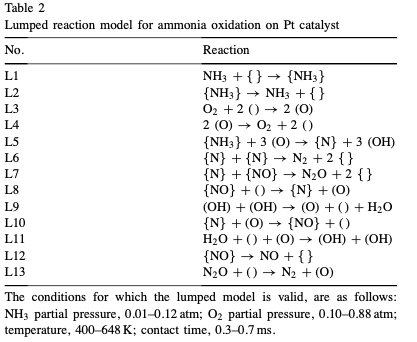

In [23]:
Image('Images/Rebrov_table2.png')

### Figure 3
#### create partial pressure, selectivity, and concentration columns in the dataframe

In [40]:
for commit in commit_list:
    data_dict[commit]['NH3(6) conversion (%)']= 100*(data_dict[commit]['X_nh3 initial'] - data_dict[commit]['NH3(6)'])/data_dict[commit]['X_nh3 initial']
    
    S_N2 = ((-2)*(data_dict[commit]['N2(4) ROP [kmol/m^3 s]']+data_dict[commit]['N2(4) surface ROP [kmol/m^2 s]'])/
            (data_dict[commit]['NH3(6) ROP [kmol/m^3 s]']+ data_dict[commit]['NH3(6) surface ROP [kmol/m^2 s]']))

    S_NO = ((-1)*(data_dict[commit]['NO(5) ROP [kmol/m^3 s]']+data_dict[commit]['NO(5) surface ROP [kmol/m^2 s]'])/
            (data_dict[commit]['NH3(6) ROP [kmol/m^3 s]']+ data_dict[commit]['NH3(6) surface ROP [kmol/m^2 s]']))

    S_N2O = ((-2)*(data_dict[commit]['N2O(7) ROP [kmol/m^3 s]']+data_dict[commit]['N2O(7) surface ROP [kmol/m^2 s]'])/
            (data_dict[commit]['NH3(6) ROP [kmol/m^3 s]']+ data_dict[commit]['NH3(6) surface ROP [kmol/m^2 s]']))
    
    data_dict[commit]['N2(4) Selectivity (%)'] = 100*S_N2 / (S_N2 + S_NO + S_N2O)
    data_dict[commit]['NO(5) Selectivity (%)'] = 100*S_NO / (S_N2 + S_NO + S_N2O)
    data_dict[commit]['N2O(7) Selectivity (%)'] = 100*S_N2O / (S_N2 + S_NO + S_N2O)

    data_dict[commit]['O_X(9) Coverage']=data_dict[commit]['O_X(9)']/(data_dict[commit]['O_X(9)'] + data_dict[commit]['OH_X(11)']+ data_dict[commit]['X(1)'])
    data_dict[commit]['OH_X(11) Coverage']=data_dict[commit]['OH_X(11)']/(data_dict[commit]['O_X(9)'] + data_dict[commit]['OH_X(11)']+ data_dict[commit]['X(1)'])
    data_dict[commit]['X(1) Coverage']=data_dict[commit]['X(1)']/(data_dict[commit]['O_X(9)'] + data_dict[commit]['OH_X(11)']+ data_dict[commit]['X(1)'])
    data_dict[commit]['NO_X(14) Coverage']=data_dict[commit]['NO_X(14)']/(data_dict[commit]['NO_X(14)'] + data_dict[commit]['N_X(13)']+ data_dict[commit]['NH3_X(8)']+ data_dict[commit]['X(1)'])
    data_dict[commit]['N_X(13) Coverage']=data_dict[commit]['N_X(13)']/(data_dict[commit]['NO_X(14)'] + data_dict[commit]['N_X(13)']+ data_dict[commit]['NH3_X(8)']+ data_dict[commit]['X(1)'])
    data_dict[commit]['NH3_X(8) Coverage']=data_dict[commit]['NH3_X(8)']/(data_dict[commit]['NO_X(14)'] + data_dict[commit]['N_X(13)']+ data_dict[commit]['NH3_X(8)']+ data_dict[commit]['X(1)'])
    data_dict[commit]['X Coverage']=data_dict[commit]['X(1)']/(data_dict[commit]['NO_X(14)'] + data_dict[commit]['N_X(13)']+ data_dict[commit]['NH3_X(8)']+ data_dict[commit]['X(1)'])


In [41]:
data_dict[commit].to_csv("rebrov_O2_data.csv")
data_dict[commit]

,Distance (mm),T (K),P (Pa),V (M^3/s),X_nh3 initial,X_o2 initial,X_he initial,(NH3/O2),T (K) final,Rtol,...,N2(4) Selectivity (%),NO(5) Selectivity (%),N2O(7) Selectivity (%),O_X(9) Coverage,OH_X(11) Coverage,X(1) Coverage,NO_X(14) Coverage,N_X(13) Coverage,NH3_X(8) Coverage,X Coverage
1000,9.0,598,101325.0,0.000058,0.066,0.126897,0.807103,0.520109,598.0,1.000000e-11,...,0.000567,99.990920,0.008513,0.999999,4.301997e-12,7.649891e-07,0.072215,0.002816,0.005708,0.919261
1000,9.0,598,101325.0,0.000058,0.066,0.153793,0.780207,0.429148,598.0,1.000000e-11,...,0.000506,99.991984,0.007510,0.999999,3.812372e-12,6.162374e-07,0.065616,0.002762,0.005749,0.925873
1000,9.0,598,101325.0,0.000058,0.066,0.180690,0.753310,0.365267,598.0,1.000000e-11,...,0.000461,99.992663,0.006875,0.999999,3.458737e-12,5.161582e-07,0.061198,0.002725,0.005776,0.930302
1000,9.0,598,101325.0,0.000058,0.066,0.207586,0.726414,0.317940,598.0,1.000000e-11,...,0.000426,99.993142,0.006432,1.000000,3.188276e-12,4.442208e-07,0.058143,0.002696,0.005795,0.933366
1000,9.0,598,101325.0,0.000058,0.066,0.234483,0.699517,0.281471,598.0,1.000000e-11,...,0.000399,99.993494,0.006108,1.000000,2.972954e-12,3.900177e-07,0.055841,0.002675,0.005810,0.935675
1000,9.0,598,101325.0,0.000058,0.066,0.261379,0.672621,0.252507,598.0,1.000000e-11,...,0.000375,99.993766,0.005859,1.000000,2.796360e-12,3.477102e-07,0.054095,0.002657,0.005820,0.937428
1000,9.0,598,101325.0,0.000058,0.066,0.288276,0.645724,0.228947,598.0,1.000000e-11,...,0.000356,99.993979,0.005665,1.000000,2.648178e-12,3.137691e-07,0.052643,0.002642,0.005829,0.938885
1000,9.0,598,101325.0,0.000058,0.066,0.315172,0.618828,0.209409,598.0,1.000000e-11,...,0.000340,99.994154,0.005506,1.000000,2.521560e-12,2.859359e-07,0.051479,0.002630,0.005837,0.940054
1000,9.0,598,101325.0,0.000058,0.066,0.342069,0.591931,0.192944,598.0,1.000000e-11,...,0.000325,99.994302,0.005373,1.000000,2.411761e-12,2.626975e-07,0.050605,0.002619,0.005842,0.940934
1000,9.0,598,101325.0,0.000058,0.066,0.368966,0.565034,0.178879,598.0,1.000000e-11,...,0.000312,99.994423,0.005264,1.000000,2.315378e-12,2.430028e-07,0.049742,0.002610,0.005848,0.941800


<AxesSubplot:xlabel='X_o2 initial', ylabel='NH3(6) conversion (%)'>

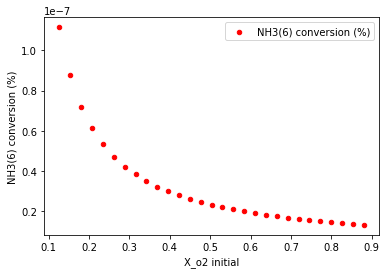

In [42]:
data_dict[commit].plot.scatter(x='X_o2 initial',y='NH3(6) conversion (%)',label='NH3(6) conversion (%)',color="r")

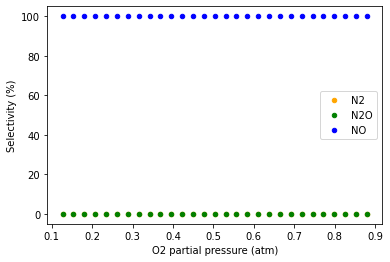

In [43]:
ax1 = data_dict[commit].plot.scatter(x='X_o2 initial',y='N2(4) Selectivity (%)',
                                     label='N2',color="orange")
ax2 = data_dict[commit].plot.scatter(x='X_o2 initial',y='N2O(7) Selectivity (%)',
                                     label='N2O',color='g', ax=ax1)
ax3 = data_dict[commit].plot.scatter(x='X_o2 initial',y='NO(5) Selectivity (%)',
                                     label='NO',color='blue', ax=ax1)
ax1.set_xlabel("O2 partial pressure (atm)")
ax1.set_ylabel("Selectivity (%)")
plt.show()

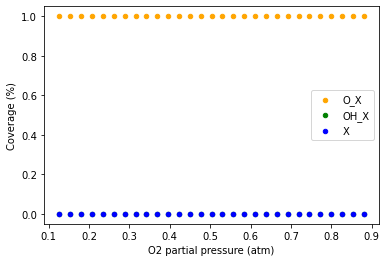

In [44]:
ax1 = data_dict[commit].plot.scatter(x='X_o2 initial',y='O_X(9) Coverage',
                                     label='O_X',color="orange")
ax2 = data_dict[commit].plot.scatter(x='X_o2 initial',y='OH_X(11) Coverage',
                                     label='OH_X',color='g', ax=ax1)
ax3 = data_dict[commit].plot.scatter(x='X_o2 initial',y='X(1) Coverage',
                                     label='X',color='blue', ax=ax1)
ax1.set_xlabel("O2 partial pressure (atm)")
ax1.set_ylabel("Coverage")
plt.show()

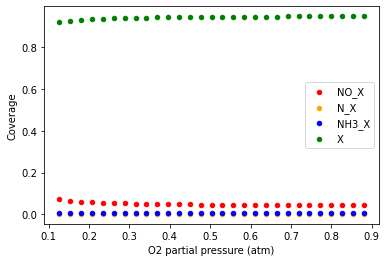

In [45]:
ax1 = data_dict[commit].plot.scatter(x='X_o2 initial',y='NO_X(14) Coverage',
                                     label='NO_X',color="r")
ax2 = data_dict[commit].plot.scatter(x='X_o2 initial',y='N_X(13) Coverage',
                                     label='N_X',color='orange', ax=ax1)
ax3 = data_dict[commit].plot.scatter(x='X_o2 initial',y='NH3_X(8) Coverage',
                                     label='NH3_X',color='b', ax=ax1)
ax4 = data_dict[commit].plot.scatter(x='X_o2 initial',y='X Coverage',
                                     label='X',color='g', ax=ax1)
ax1.set_xlabel("O2 partial pressure (atm)")
ax1.set_ylabel("Coverage")
plt.show()

### For Rebrov's selectivity definitions:

In [ ]:
for commit in commit_list:
    L5 = data_dict[commit]['NH3_X(8) + O_X(9) <=> NH2_X(10) + OH_X(11) ROP [kmol/m^2 s]']+data_dict[commit]['NH2_X(10) + O_X(9) <=> NH_X(12) + OH_X(11) ROP [kmol/m^2 s]']+data_dict[commit]['NH_X(12) + O_X(9) <=> N_X(13) + OH_X(11) ROP [kmol/m^2 s]']
    L6 = data_dict[commit]['2 N_X(13) <=> N2(4) + 2 X(1) ROP [kmol/m^2 s]']
    L7 =  data_dict[commit]['NO_X(14) + N_X(13) <=> N2O(7) + 2 X(1) ROP [kmol/m^2 s]']
    L12 = data_dict[commit]['NO_X(14) <=> NO(5) + X(1) ROP [kmol/m^2 s]']
    L13 = data_dict[commit]['N2O(7) + X(1) <=> N2(4) + O_X(9) ROP [kmol/m^2 s]'] 

    S_N2 = 2*(L6+L13)/L5
    S_N2O = 2*(L7-L13)/L5
    S_NO = 1*L12/L5
    data_dict[commit]['N2(4) Selectivity (%)'] = 100*S_N2 / (S_N2 + S_NO + S_N2O)
    data_dict[commit]['NO(5) Selectivity (%)'] = 100*S_NO / (S_N2 + S_NO + S_N2O)
    data_dict[commit]['N2O(7) Selectivity (%)'] = 100*S_N2O / (S_N2 + S_NO + S_N2O)

# data_dict[commit]['N2(4) Selectivity (%)']
# data_dict[commit]['NO(5) Selectivity (%)']
# data_dict[commit]['N2O(7) Selectivity (%)']

### Use this if run RMG on master

In [ ]:
for commit in commit_list:
    for i in conversion_species:
        data_dict[commit]['NH3(6) conversion (%)'] = 100*(data_dict[commit]['X_nh3 initial'] - data_dict[commit][i])/data_dict[commit]['X_nh3 initial']
    
    for i in selectivity_species:
        data_dict[commit][f'{i} Selectivity (%)'] = 100*(data_dict[commit][i])/(data_dict[commit]['X_nh3 initial'] - data_dict[commit]['NH3(6)'])

    for i in coverage_species_1:
        data_dict[commit][f'{i} Coverage'] = (data_dict[commit][i])/(data_dict[commit]['OX(10)'] + data_dict[commit]['HOX(13)']+ data_dict[commit]['X(1)'])
    
    for i in coverage_species_2:
        data_dict[commit][f'{i} Coverage'] = (data_dict[commit][i])/(data_dict[commit]['NO_ads(27)'] + data_dict[commit]['N_ads(64)']+ data_dict[commit]['H3NX(29)']+ data_dict[commit]['X(1)'])
        

In [ ]:
ax1 = data_dict[commit].plot(x='X_nh3 initial',y='OX(10) Coverage',
                                     label='O_X',color="orange")
ax2 = data_dict[commit].plot(x='X_nh3 initial',y='HOX(13) Coverage',
                                     label='OH_X',color='g', ax=ax1)
ax3 = data_dict[commit].plot(x='X_nh3 initial',y='X(1) Coverage',
                                     label='X',color='blue', ax=ax1)
ax1.set_xlabel("NH3(6) partial pressure (atm)")
ax1.set_ylabel("Coverage (%)")
plt.show()

In [ ]:
ax1 = data_dict[commit].plot(x='X_nh3 initial',y='NO_ads(27) Coverage',
                                     label='NO_X',color="r")
ax2 = data_dict[commit].plot(x='X_nh3 initial',y='N_ads(72) Coverage',
                                     label='N_X',color='orange', ax=ax1)
ax3 = data_dict[commit].plot(x='X_nh3 initial',y='H3NX(29) Coverage',
                                     label='NH3_X',color='b', ax=ax1)
ax4 = data_dict[commit].plot(x='X_nh3 initial',y='X Coverage',
                                     label='X',color='g', ax=ax1)
ax1.set_xlabel("NH3(6) partial pressure (atm)")
ax1.set_ylabel("Coverage (%)")
plt.show()